In [1]:
# coding: utf-8
import ast
import os
import sys
import re
import numpy as np
from pprint import pprint

from func import simulation as sim

run_name = 'test'

In [2]:
my_amino_acid_order = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y',"*"]
codon_table = {
                'A': ['GCT', 'GCC', 'GCA', 'GCG'],
                'C': ['TGT', 'TGC'],
                'D': ['GAT', 'GAC'],
                'E': ['GAA', 'GAG'],
                'F': ['TTT', 'TTC'],
                'G': ['GGT', 'GGC', 'GGA', 'GGG'],
                'H': ['CAT', 'CAC'],
                'I': ['ATT', 'ATC', 'ATA'],
                'K': ['AAA', 'AAG'],
                'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
                'M': ['ATG'],
                'N': ['AAT', 'AAC'],
                'P': ['CCT', 'CCC', 'CCA', 'CCG'],
                'Q': ['CAA', 'CAG'],
                'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
                'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
                'T': ['ACT', 'ACC', 'ACA', 'ACG'],
                'V': ['GTT', 'GTC', 'GTA', 'GTG'],
                'W': ['TGG'],
                'Y': ['TAT', 'TAC'],
                "*": ['TAG','TAG','TAA']
                }

In [3]:
# Define the DMS library;

###########################
# Starting from cloning
###########################

# Ways to create DMS libraries;
# 1. One-shot (whole region) suynthesis 
# 2. Synthesize per position (and pool)     <- This is used mainly in Landry lab.
# 3. Error prone PCR

########################################
# 2. Synthesize per position (and pool)

dms_region_len = 200


# Based on available DMS data, get the following paramaters
# For each position, get the CV of each codon 
CV_codon  = 0.05 # here, i randomly set it at 30%  
CFU_codon = 10000 # here, i randomly set it at 10000. This is the bottleneck before mixing library.

# For the entire region, get the CV of each position 
CV_pos  = 0.01 # here, i randomly set it at 30%  
CFU_pos = 100000 # here, i randomly set. This is the bottleneck for pos library.



# First, define the position library
DMS_lib = []
for i in range(dms_region_len):
    pos = i +1
    pos_lib = []
    for amino_acid in my_amino_acid_order:
        for codon in codon_table[amino_acid]:
            pos_lib.append({"codon":codon,"amino_acid":amino_acid,"count":1,"position":pos})
    pos_lib =  sim.adjust_num_d(pos_lib,CV_codon,CFU_codon)
    
    DMS_lib.append(pos_lib)

# Mix each of the positions to one big library
DMS_lib_2 = sim.adjust_num_d_positions(DMS_lib,CV_pos,CFU_pos)    

In [4]:
# Show coverage of each construct
#pprint(DMS_lib_2)
cov = sim.dms_coverage(DMS_lib_2)
print("The ratio of constructs having at lesat the number of molecules above threshold.")
sim.print_LL(cov)


The ratio of constructs having at lesat the number of molecules above threshold.
Threashold	Percentage
1   	100.0
10  	0.02
100 	0.0 


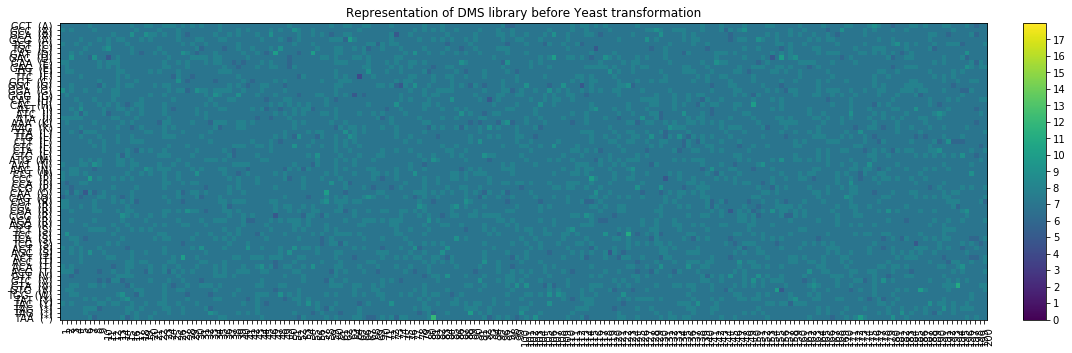

In [5]:
# Organize data and show heatmap
title = "Representation of DMS library before Yeast transformation"
sim.plot_DMS_hm(DMS_lib_2,title)

In [6]:
#next steps:
# 1. Yeast transformation
# 2. Preculture
# 2. Selection
# 3. Genomic prep/ plsmid prep
# 4. Sequencing

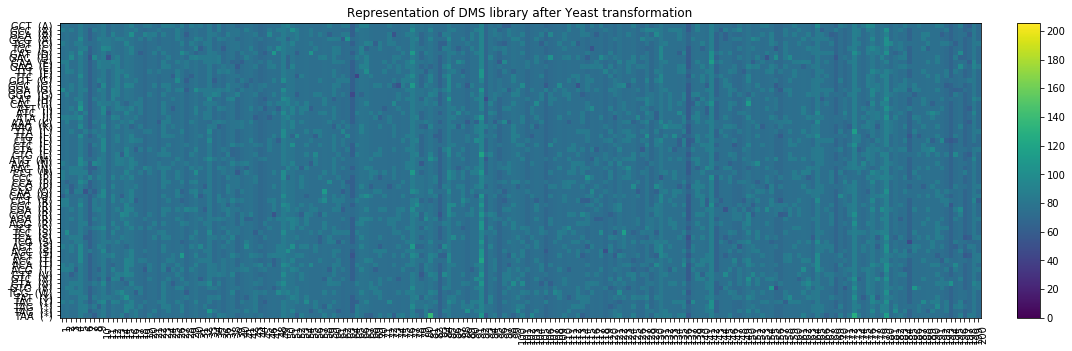

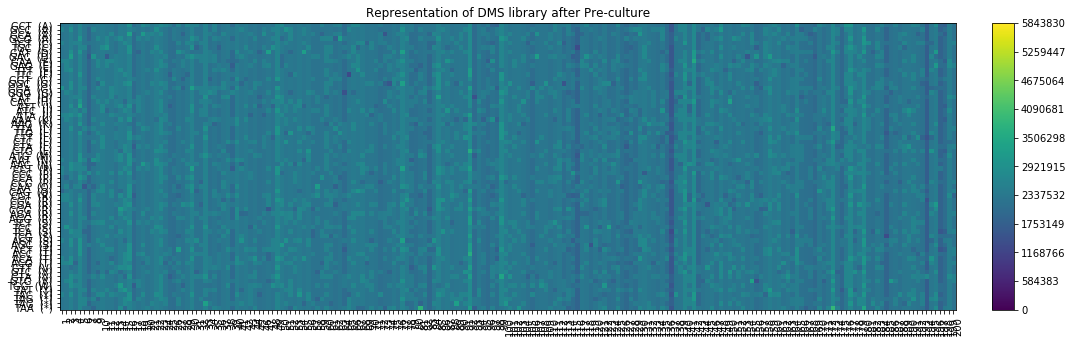

In [7]:
###############################################################
# Yeast transformation and pre-culture

CV_YstTrnsfmtn  = 0.05 # here, i randomly set it at 30%  
CFU_YstTrnsfmtn = 1000000 # here, i randomly set it at 10000. 

DMS_lib_Yst = sim.adjust_num_d_positions(DMS_lib_2,CV_YstTrnsfmtn,CFU_YstTrnsfmtn)    

title = "Representation of DMS library after Yeast transformation"
sim.plot_DMS_hm(DMS_lib_Yst,title)

CV_PrCltr  = 0.05 # here, i randomly set it at 30%  
OD_PrCltr  = 1000 # here, i randomly set it at 100.
Clls_PrCltr= OD_PrCltr * 3*10**7 # 1 OD unit of haploid cells = 3 x 10^7. change this to 1 x 10^7 if using diploid
# This is the amount you are carrying over to next step

DMS_lib_PrCltr = sim.adjust_num_d_positions(DMS_lib_Yst,CV_PrCltr,Clls_PrCltr)    


title = "Representation of DMS library after Pre-culture"
sim.plot_DMS_hm(DMS_lib_PrCltr,title)

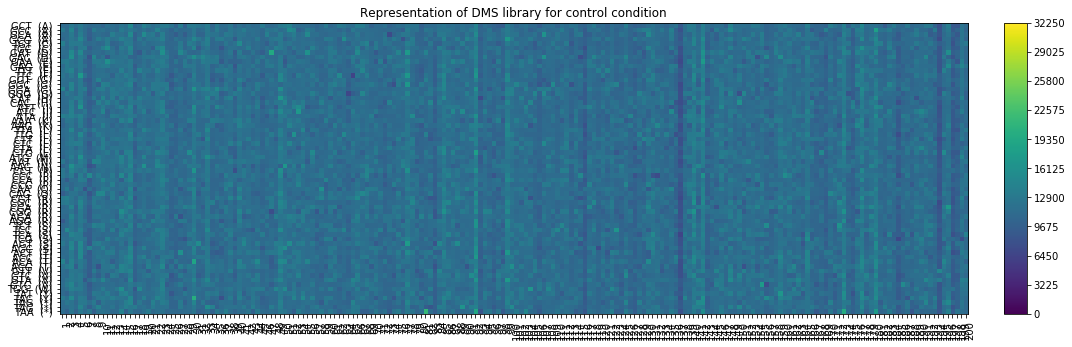

In [8]:
# # Selection

lethality_rate_codon   = 0.80 # How many of the constructs have the less growth compared to WT
CV_slctn               = 0.5    # Log CV for codon dependent negative

lethality_rate_pos     = 0.50 # How many of the constructs have the less growth compared to WT
CV_pos                 = 0.15   # Log CV for position dependent negative 


OD_DNA_prep = 5
Clls_DNA_prep= OD_DNA_prep * 3*10**7 # 1 OD unit of haploid cells = 3 x 10^7. change this to 1 x 10^7 if using diploid

CV_control  = 0.05 # here, i randomly set it at 30%

#pprint(DMS_lib_PrCltr)

DMS_lib_Cntrl = sim.adjust_num_d_dms(DMS_lib_PrCltr,CV_control,Clls_DNA_prep)    
title = "Representation of DMS library for control condition"
sim.plot_DMS_hm(DMS_lib_Cntrl,title)


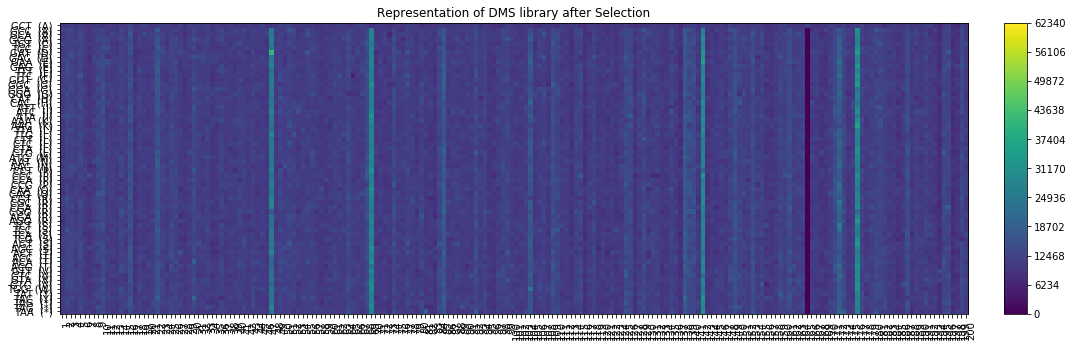

In [9]:

DMS_lib_Slctn = sim.dms_selection(DMS_lib_PrCltr,CV_pos,CV_codon,lethality_rate_codon,lethality_rate_pos,Clls_DNA_prep)    
title = "Representation of DMS library after Selection"
sim.plot_DMS_hm(DMS_lib_Slctn,title)


In [10]:

#===== YOU NEED TO ESTIMATE THE PARAMATER =========
###################################################
# Molecule estimation from DNA prep
#
# Fraction of desired product in yeast DNA miniprep product is XXX% of the total DNA mass
# = Reference for 2-micron+ strain using Yeast mini prep kit=
# Fraction of Y2H (CEN) plasmid in yeast DNA miniprep product is 6% of the total DNA mass
# If so, Fraction of desired product = 10 * 0.06 = 600 pg
# = 
# 
# Plasmid sizes are 10 kbp
# 1 mole of double-stranded DNA molecule is 660 g bp^-1 (1ng = 0.152 fmol)
# 600 * (1/1000 * 0.152) fmol    = 600 * 10**-3 * 0.152 * 10**-15 * 6.03* 10**23
#                                = 600 * 6.03 * 0.152 * 10**5
######################################################
CV_dnaPrep_Cntrl  = 0.1 # here, i randomly set it at 30%  
ng_dnaPrep_Cntrl  = 10  # Put the amount you are subjecting to PCR.
size_dna_Cntrl    = 10000 # assuming the region is on a plasmid 10000-bp 
mols_dnaPrep_Cntrl= 600 * 6.03 * 0.152 * 10**5


CV_dnaPrep_Slctn  = 0.1 # here, i randomly set it at 30%  
ng_dnaPrep_Slctn  = 10  # Put the amount you are subjecting to PCR.
size_dna_Slctn    = 10000 # assuming the region is on a plasmid 10000-bp 
mols_dnaPrep_Slctn= 600 * 6.03 * 0.152 * 10**5

dna_cntrl         = sim.adjust_num_d_dms(DMS_lib_Cntrl,CV_dnaPrep_Cntrl,mols_dnaPrep_Cntrl)   
dna_slctn         = sim.adjust_num_d_dms(DMS_lib_Slctn,CV_dnaPrep_Slctn,mols_dnaPrep_Slctn)   



###############################################################
# PCR re-amplification and Illumina sequencing
reads_per_condition = 20* 10**6 # Reads for each condition 






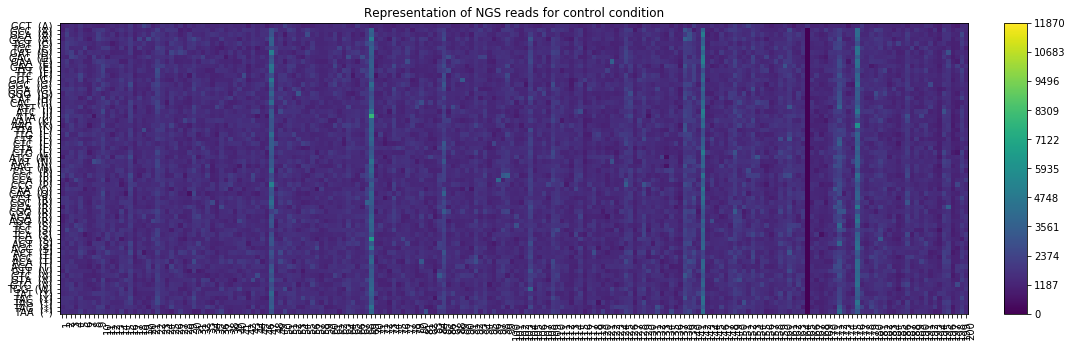

In [11]:
title = "Representation of NGS reads for control condition"
read_cntrl = sim.adjust_num_d_dms(dna_cntrl,0.01,reads_per_condition)
sim.plot_DMS_hm(read_cntrl,title)

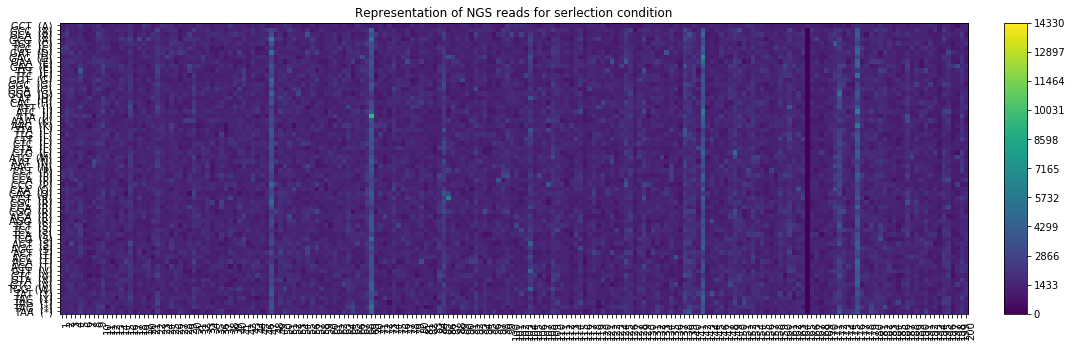

In [12]:
title = "Representation of NGS reads for serlection condition"
read_slctn = sim.adjust_num_d_dms(dna_slctn,0.15,reads_per_condition)
sim.plot_DMS_hm(read_slctn,title)